## `TimeSeries Forecasting Model`
* <b>File Name</b> : Reference_implementation
* <b>Date of creation(dd-mm-yyyy)</b> : 08-05-2023
* <b>Author Name/Dept</b> : AIShield
* <b>Organization</b> : BGSW
* <b>Description</b> : Source Code of reference implementation
* <b>Copyright</b> : Copyright 2022 Bosch Global Software Technologies Private Limited. All Rights Reserved.

### Metadata
* <b>Dataset</b> : pumpsensor
* <b>Size of training set</b>: 50000
* <b>Size of testing set</b> : 164251
* <b>Original Model</b>: LSTM

### Outcomes
* <b>RMSE Score of model</b>: 0.043

<a target="_blank" href="https://colab.research.google.com/github/bosch-aisecurity-aishield/Reference-Implementations/blob/main/Product_Taskpair_wise/TimeSeries_Forecasting/Extraction/PyPi_Extraction_Reference_Implementation_TSF_DL.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# # Install AIShield SDK.
# # If not already installed, install by uncommenting the code below

# !pip install aishield

In [2]:
"""
Description: commands to install all the packages, remove comments to install all the libraries
"""
# ! pip install xgboost==1.6.2
# ! pip install pandas==1.5.1
# ! pip install scikit-learn==1.1.3
# ! pip install numpy==1.23.4
# ! pip install pyminizip
# !pip install requests==2.28.0
# !pip install humanfriendly==9.2

'\nDescription: commands to install all the packages, remove comments to install all the libraries\n'

## `1.0 Import Libraries`

In [4]:
"""
Description: Import libraries
"""
import os 
import cv2
import os
import json
import time
import shutil
import random
import zipfile
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model

#importing AIShield Library
import aishield as ais

## `2.0 Data Loading and Pre-processing`

#### Download dataset from the link https://www.kaggle.com/code/winternguyen/water-pump-maintenance-shutdown-prediction/input

1. then download the sensor.csv file

In [5]:
'''
Description : Loading pumpsensor dataset
'''

data =  pd.read_csv("C:/Users/tnq1kor/Downloads/sensor/sensor.csv")

In [6]:
# Let remove first all NaN columns and all columns have zero standard values
data.drop(['Unnamed: 0', 'timestamp','sensor_00','sensor_15','sensor_50','sensor_51'],axis=1, inplace=True)

conditions = [(data['machine_status'] =='NORMAL'), (data['machine_status'] =='BROKEN'), (data['machine_status'] =='RECOVERING')]
choices = [1, 0, 0.5]
data['Operation'] = np.select(conditions, choices, default=0)

In [7]:
df = pd.DataFrame(data, columns=['sensor_04', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09','Operation'])

In [8]:
'''
Description : Normalized the dataset 
'''

values = df.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [9]:
'''
Description : convert normalized dataset to a dataframe 
'''

df_scaled = pd.DataFrame(scaled, columns=df.columns)
df_scaled = df_scaled.dropna()

In [10]:
'''
Description : choosing train and testing dataset
'''

df_train = df_scaled.iloc[:50000,:]
df_test = df_scaled.iloc[50000:,:]

In [11]:
'''
Description : convert series to supervised learning
''' 

def series_to_supervised(data, n_vars_out, n_in, n_out=1, fillnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i).iloc[:,n_vars_out])
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in (n_vars_out)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in (n_vars_out)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # Replace nan values with 0
    if fillnan:
        agg = agg.fillna(0)
    return agg

In [12]:
'''
Description : convert input dims to number of timesteps and number of features and 
            generate data samples by window sliding through time series data
'''

def data_prep(df, input_dims, pred_out):    
    # convert input dims to number of timesteps and number of features
    num_timesteps, num_features = 100,6#input_dims
    
    # generate data samples by window sliding through time series data
    reframed = series_to_supervised(df, pred_out, num_timesteps)
    data = reframed.values
    
    # split into input and outputs
    n_obs = num_timesteps*num_features  # no. of timesteps * features 
    data_x, data_y = data[:, :n_obs], data[:, n_obs:]
    
    # reshape input to be 3D [samples, timesteps, features]
    data_x = data_x.reshape((data_x.shape[0], num_timesteps, num_features))
    
    return data_x, data_y

In [13]:
'''
Description : Splitting data for training and testing 
'''

input_shape = (100,6)
pred_col_index = [len(df_train.columns) - 1]
x_train, y_train = data_prep(df_train, input_shape, pred_col_index)
x_test, y_test = data_prep(df_test, input_shape, pred_col_index)

In [14]:
'''
Description : Check size of dataset
'''
print("x_train Shape :",x_train.shape)
print("y_train Shape:",y_train.shape)
print("x_test Shape:",x_test.shape)
print("y_test Shape:",y_test.shape)

x_train Shape : (50000, 100, 6)
y_train Shape: (50000, 1)
x_test Shape: (164251, 100, 6)
y_test Shape: (164251, 1)


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

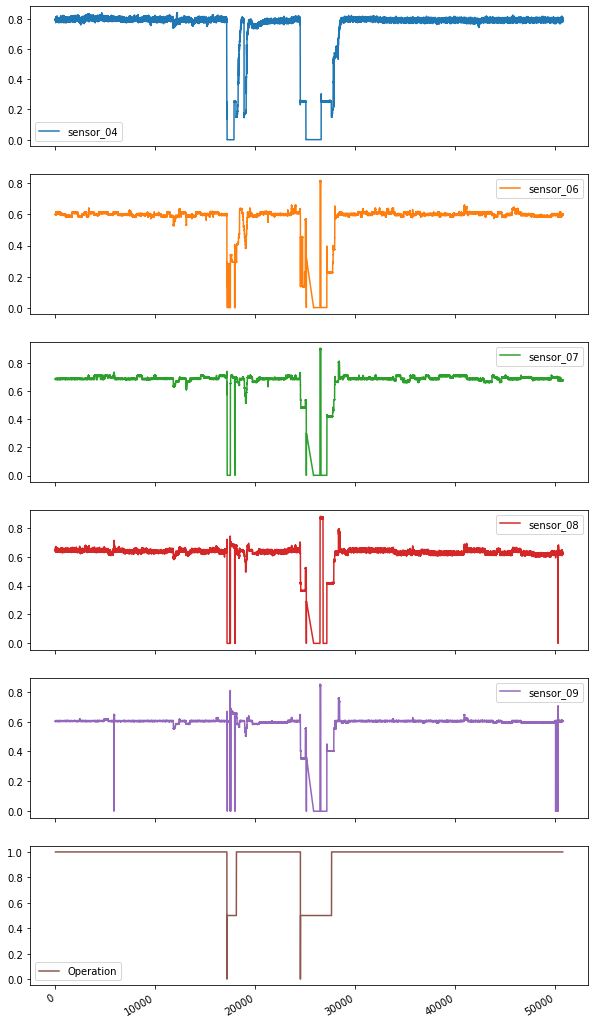

In [15]:
'''
Description : Plotting the graphs
'''

df_train.plot(subplots =True, sharex = True, figsize = (10,20))

In [16]:
def make_directory(directory):
    """
    create directory

    Parameters
    ----------
    directorys : list containing the directorys path to create 
    Returns
    -------
    None.

    """
    for d in directory:
        if os.path.isdir(d):
            print("directory {} already exist".format(d))
        if os.path.isdir(d)==False:
            os.mkdir(path=d)
            print("directory {} created successfully".format(d))

In [17]:
def delete_directory(directorys):
    """
    delete directory 

    Parameters
    ----------
    directorys : list containing the directorys to deleate along with all the files

    Returns
    -------
    None.

    """
    if len(directorys)>=1:
        for d in directorys:
            if os.path.isdir(d):
                try:
                    if os.path.isfile(d):
                        os.remove(path=d)
                    else:
                        shutil.rmtree(path=d)
                        print("Removed: {}".format(d))
                except:
                    print("Failed to removed: {}".format(d))
            else:
                print("Failed to removed: {}".format(d))
                

In [18]:
def make_archive(base_name,root_dir,zip_format='zip'):
    """
    created zip for given folder

    Parameters
    ----------
    base_name : name of zip file
    root_dir : directory to archive/zip
    zip_format : zip or tar 
        DESCRIPTION. The default is 'zip'.

    Returns
    -------
    None.

    """
    shutil.make_archive(base_name=base_name, format=zip_format, root_dir=root_dir)
    

In [72]:
'''
Description : Create data, model and label folder
'''

data_path=os.path.join(os.getcwd(),"data")
model_path=os.path.join(os.getcwd(),"model")
minmax_path=os.path.join(os.getcwd(),"minmax")
zip_path=os.path.join(os.getcwd(),"zip")
pyc_model_path=os.path.join(os.getcwd(),"pycmodel")
report_path = os.path.join(os.getcwd(),"reports")

#deleting folder
delete_directory(directorys=[data_path,model_path,minmax_path,zip_path,pyc_model_path,report_path])

#creating folder
make_directory([data_path,model_path,minmax_path,zip_path,pyc_model_path,report_path])

'\nDescription : Create data, model and label folder\n'

## `3.0 Model Development and Training`


In [20]:
"""
Description: Create model architecture
"""

def getmodel():
    model = Sequential()
    model.add(LSTM(100, input_shape=(100,6)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [21]:
"""
Description: to get root mean squared error of the model 
"""

def RMSE_score(model, test_x, test_y):
    pred_y = model.predict(test_x)
    return np.sqrt(mean_squared_error(pred_y, test_y))


In [22]:
"""
Description: Model summary
"""

model= getmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,901
Trainable params: 42,901
Non-trainable params: 0
_________________________________________________________________


In [23]:
"""
Description: Training model
"""

history = model.fit(x_train, y_train, epochs=2, batch_size=70, validation_data=(x_test, y_test), verbose=2, shuffle=False)

Epoch 1/2
715/715 - 23s - loss: 0.0097 - val_loss: 0.0014 - 23s/epoch - 33ms/step
Epoch 2/2
715/715 - 19s - loss: 0.0045 - val_loss: 0.0021 - 19s/epoch - 26ms/step


In [24]:
"""
Description: get rmse score 
"""

RMSE_score(model,x_test, y_test)

5133/5133 [==============================] - 17s 3ms/step


0.04617829978707208

In [25]:
"""
Saving the model under model directory
"""
model_name = "org_model.h5"
model.save(os.path.join(model_path,model_name))

## `4.0 Prepare Data , Model and MinMax`

In [26]:
"""
Description: Zip Data
"""
df_test.to_csv(os.path.join(data_path,"data.csv"),index=False)
make_archive(base_name=os.path.join(zip_path,"data"),root_dir=data_path,zip_format='zip')

### `4.0.1 Prepare and creating minmax.zip file`

In [27]:
'''
Description: Preparing Min_Max file
'''
min_values = df_test.min().to_numpy()
max_values = df_test.max().to_numpy()
x = np.array([min_values,max_values])
df_m = pd.DataFrame(x,columns=df_test.columns)
df_m.to_csv(minmax_path+'/minmax.csv',index = False)

In [28]:
"""
Description: Minmax label
"""
make_archive(base_name=os.path.join(zip_path,"minmax"),root_dir=minmax_path,zip_format='zip')

## `4.1.0 Convert python script (.py) to (.pyc)`


In [29]:
"""
Description: save weight of model
"""

model.save_weights(os.path.join(pyc_model_path,"model_weight.h5"))

In [30]:
"""
Description: Create encrypted Model
"""

python_code='''
#import library
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, LSTM, Dense

"""
    class for base model
"""
#define class
class BaseModel():

    
    def __init__(self,input_shape=(100,6),model_weight_path="model_weight.h5"):

        """
        constructor for class

        Parameters
        ----------
        input_shape : TYPE, optional
            DESCRIPTION. The default is (100,6).
        model_weight_path : string, optional
            DESCRIPTION. the relative path to model weight

        Returns
        -------
        None.

        """

        self.input_shape=input_shape
        self.model_weight_path=model_weight_path
        

    def get_model(self,input_shape):

        """
        model architecture

        Parameters
        ----------
        input_shape : string
            DESCRIPTION.input_shape for model e.g (100,6)
        
        Returns
        -------
        model : model
            DESCRIPTION.

        """
        
        model = Sequential()
        model.add(LSTM(100, input_shape=self.input_shape))
        model.add(Dropout(0.2))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        
        return model
    
    def predict(self,X):
        """
        predict for given data

        Parameters
        ----------
        X : numpy array 
            DESCRIPTION.

        Returns
        -------
        pred : numpy array
            DESCRIPTION.

        """

        model=self.get_model(input_shape=self.input_shape)
        model.load_weights(self.model_weight_path)
        
        pred=model.predict(X)
        return pred  '''

In [31]:
# Writing to file
with open("base_model.py", "w") as file:
    # Writing data to a file
    file.writelines(python_code)

In [71]:
"""
Description: function to create .pyc file
"""

import py_compile
py_compile.compile(file='base_model.py',cfile=os.path.join(pyc_model_path,'base_model.pyc'))

'\nDescription: function to create .pyc file\n'

* .pyc file with name base_model.pyc will get created
* delete .py file and still import and other function will work
* while AIShield API call , inplace of model.h5 file you can zip .pyc and model weight which will provide security to internal architecture

In [33]:
"""
Description: check import from .pyc file
"""
from pycmodel.base_model import BaseModel
base_model=BaseModel(model_weight_path=r"pycmodel/model_weight.h5")

In [34]:
"""
Description : getting prediction from function imported from .pyc file
"""
print(base_model.predict(x_test[:1]))

1/1 [==============================] - 0s 315ms/step
[[0.36480737]]


In [35]:
"""
Description: Zip model
"""
model_encryption=0 #0 if model is uploaded directly as a zip, 1 if model is encryted as .pyc and uploaded as a zip
if os.path.isfile(os.path.join(zip_path,"model.zip")):
    delete_directory(directorys=[os.path.join(zip_path,"model.zip")])
if model_encryption:
    make_archive(base_name=os.path.join(zip_path,"model1"),root_dir=pyc_model_path,zip_format='zip')
else:
    make_archive(base_name=os.path.join(zip_path,"model0"),root_dir=model_path,zip_format='zip')

## `5.0 AIShield API Call`

In [34]:
"""
Description: AIShield API URL and subscription key
""" 

baseurl = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" # fill in API endpoint url from AIShield developer portal under API tab 
url = baseurl + "/api/ais/v1.5"
headers={'Cache-Control': 'no-cache',
'x-api-key': "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXx", # fill in subscription key from AIShield developer portal under My Dashboard tab
'Org-Id' : "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX"  # fill in Org_Id provided in welcome email
}

In [37]:
"""
Description: File paths
"""
data_path=os.path.join(zip_path,'data.zip') #full path of data zip
minmax_path=os.path.join(zip_path,'minmax.zip') #full path of label zip
model_path=os.path.join(zip_path,'model0.zip') #full uppath of model zip

### `Perform Vulnerability Analysis through VulConfig Function`

In [38]:
"""
Description: Initialize the AIShield API
"""
client = ais.AIShieldApi(api_url=url, api_key=api_key, org_id=org_id)

In [39]:
"""
Description: Define the task and analysis type
"""
task_type = ais.get_type("task", "timeseries_forecasting")
analysis_type = ais.get_type("analysis", "extraction")

In [40]:
"""
Description: Perform model registration and upload the input artifacts
"""
status, job_details = client.register_model(task_type=task_type, analysis_type=analysis_type)
model_id = job_details.model_id
# print('Model id: {} \nInput artifacts will be uploaded as:\n data_upload_uri: {}\n label_upload_uri: {}'
#       '\n model_upload_uri: {}'.format(model_id, job_details.data_upload_uri, job_details.label_upload_uri,
#                                        job_details.model_upload_uri))

upload_status = client.upload_input_artifacts(job_details=job_details,
                                              data_path=data_path,
                                              minmax_path=minmax_path,
                                              model_path=model_path, )
print('Upload status: {}'.format(', '.join(upload_status)))

Upload status: data file upload successful, minmax file upload successful, model file upload successful


In [41]:
"""
Description: Specify the appropriate configs required for vulnerability analysis
"""

vuln_config = ais.VulnConfig(task_type=task_type,
                             analysis_type=analysis_type,
                             defense_generate=True)

vuln_config.input_dimensions = (100,6)  # input dimension for mnist digit classification
vuln_config.attack_type = "greybox"  # greybox or blackbox depending upon the availability of information about Model, Data and Parameters
vuln_config.number_of_attack_queries = 6000  # Number of attack queries to be generated for testing model vulnerability 
vuln_config.encryption_strategy = 0  # value 0 (or) 1, if model is unencrypted or encrypted(pyc) respectively
print('TSF-Extraction parameters are: \n {} '.format(vuln_config.get_all_params()))

TSF-Extraction parameters are: 
 {'attack_type': 'greybox', 'defense_bestonly': 'no', 'encryption_strategy': 0, 'input_dimensions': '(100, 6)', 'model_api_details': '', 'model_framework': 'tensorflow', 'number_of_attack_queries': 6000, 'use_model_api': 'no', 'vulnerability_threshold': 0} 


In [70]:
"""
Description: Run vulnerability analysis
"""
my_status, job_details = client.vuln_analysis(model_id=model_id, vuln_config=vuln_config)
my_job_id = job_details.job_id
print('status: {} \nJob_id: {} '.format(my_status, my_job_id))

status: success 
Job_id: XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX 


In [68]:
"""
Description: Monitor progress for given Job ID using the Link below
"""
print('Click on the URL to view Vulnerability Dashboard (GUI): {}'.format(job_details.job_monitor_uri))

'\nDescription: Monitor progress for given Job ID using the Link below\n'

In [44]:
"""
Description: Fetch Job status using Job ID
"""
my_status = client.job_status (job_id = my_job_id)
print('job status ', my_status)

2023-06-07 14:04:52,737 - INFO - Fetching job details for job id gAAAAABkgEEgQGM11S8q_2aMO0LXBHDlhEX2Mz0Xcam_mp5vYh5zY0Kld5grcDOASb0bxTryUVa1rK9v8rHCwxUitGQQmZ1JlQ==
2023-06-07 14:04:58,230 - INFO - ModelExploration_Status:inprogress


2023-06-07 14:05:57,156 - INFO - ModelExploration_Status:completed
2023-06-07 14:05:57,157 - INFO - SanityCheck_Status:passed
2023-06-07 14:05:57,158 - INFO - QueryGenerator_Status:inprogress


2023-06-07 14:06:13,234 - INFO - QueryGenerator_Status:completed


2023-06-07 14:06:18,547 - INFO - VunerabilityEngine_Status:inprogress


2023-06-07 14:09:36,688 - INFO - VunerabilityEngine_Status:completed
2023-06-07 14:09:36,689 - INFO - DefenseReport_Status:inprogress


2023-06-07 14:11:25,029 - INFO - DefenseReport_Status:completed
2023-06-07 14:11:25,029 - INFO - Analysis completed for job id gAAAAABkgEEgQGM11S8q_2aMO0LXBHDlhEX2Mz0Xcam_mp5vYh5zY0Kld5grcDOASb0bxTryUVa1rK9v8rHCwxUitGQQmZ1JlQ==


job run completed
job status  success


### `Saving the Artifacts and the Reports`

In [67]:
"""
Description: Creating a directory to save the defense artifacts
"""
OUTPUT_PATH = os.path.join(os.getcwd(),"Output_Artifacts")
make_directory([OUTPUT_PATH])

'\nDescription: Creating a directory to save the defense artifacts\n'

In [66]:
"""
Description: Download the Vulnerability Report
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "vulnerability"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Vulnerability Report\n'

In [65]:
"""
Description: Download the Defense Reports
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    my_report = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Defense Reports\n'

In [64]:
"""
Description: Download the Defense artifacts: Model
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "defense_artifact"),
                                 file_format=ais.get_type("file_format", "pdf"),
                                 save_folder_path=OUTPUT_PATH)
        
    defense_artifact = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Defense artifacts: Model\n'

In [63]:
"""
Description: Download the Attack Samples
"""
if my_status == "success":
    output_conf = ais.OutputConf(report_type=ais.get_type("report", "attack_samples"),
                                 save_folder_path=OUTPUT_PATH)
        
    attack_samples = client.save_job_report(job_id=my_job_id, output_config=output_conf)

'\nDescription: Download the Attack Samples\n'

In [50]:
def zip_extractor(file, extract_path=None, delete_zip=False):
    """
    extract zip file to the given path

    Parameters
    ----------
    file : path of zip file
    extract_path : path to extract zip file, default considered parent directory
    delete_zip: True, delete zip file after unzipping it

    Returns
    -------
    None.
    """
    if extract_path is None:
        extract_path = os.path.dirname(file)
    print("Extracting : {}".format(file))
    zf = zipfile.ZipFile(file=file, mode='r')
    zf.extractall(extract_path)
    zf.close()
    if delete_zip:
        os.remove(file)
        print("{} removed successfully.".format(file))


In [62]:
"""
Description: Extracting defense artifact
"""

zip_extractor(file=defense_artifact)

'\nDescription: Extracting defense artifact\n'

In [61]:
"""
Description: Extracting attack sample
"""

zip_extractor(file=attack_samples)

'\nDescription: Extracting attack sample\n'

In [53]:
attack = pd.read_csv(os.path.join(OUTPUT_PATH,'attack_samples.csv'))

In [54]:
"""
Description: Load defense model
"""

defense_model_path = os.path.join(OUTPUT_PATH, 'defense_model.h5')
defense_model = tf.keras.models.load_model(defense_model_path)

In [55]:
defense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 100, 6)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 16)            304       
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 16)            784       
                                                                 
 dense_2 (Dense)             (None, 96, 32)            544       
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 2)                 6146      
                                                                 
Total params: 7,778
Trainable params: 7,778
Non-trainable p

In [58]:
"""
Description: Use defense model
"""

from Output_Artifacts import predict
defense = predict.AISDefenseModel(defense_model,input_shape = (100,6), pre_processed = False)

In [59]:
org_pred, org_pred_prob= defense.predict(df_test[:10])
print(org_pred.tolist())

1/1 [==============================] - 1s 1s/step


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 9804.36it/s]

['not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack']


In [60]:
attack_pred, attack_pred_prob= defense.predict(attack)
print(attack_pred.tolist())

10/10 [==============================] - 0s 8ms/step


100%|████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<?, ?it/s]

['not-attack', 'not-attack', 'not-attack', 'not-attack', 'not-attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack', 'attack',